In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Streamline DWL to 3 CLASSES

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
img_00 = np.load('/content/drive/MyDrive/model_images/Train_Label/NP/10.npy')

In [ ]:
img_00[np.all(img_00 == (0, 0, 0), axis = -1)] = (0, 0, 255)
img_00[np.all(img_00 == (1, 1, 1), axis = -1)] = (0, 255, 0)
img_00[np.all(img_00 == (2, 2, 2), axis = -1)] = (255, 0, 0)

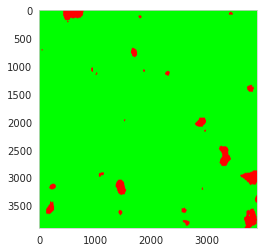

In [ ]:
plt.imshow(img_00)

## FCN Model with VGG pretrained weights

In [ ]:
dir_seg = '/content/drive/MyDrive/Capstone Data/2. DWL Label/PNG/GEE_Dynamic_2016_three_class'
dir_img = '/content/drive/MyDrive/Capstone Data/1. GEE Train/PNG/GEE_2016'

In [ ]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:

## seaborn has white grid by default so I will get rid of this.
sns.set_style("whitegrid", {'axes.grid' : False})


ldseg = np.array(os.listdir(dir_seg))
## pick the first image file
fnm = ldseg[0]
fnm = fnm.split('.')[0]
fnm1 = fnm.replace('_', '')

## read in the original image and segmentation labels
seg = np.load(dir_seg + fnm + '.npy') # (360, 480, 3)
img_is = cv2.imread(dir_img + fnm1 + '.tif')
print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))

## Check the number of labels
n_classes = 3

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

fig = plt.figure(figsize=(15,10))
for k in range(3):
    ax = fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))

plt.show()

In [ ]:
import random
def give_color_to_seg_img(seg,n_classes):
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape) == 3:
        seg = seg[:, :, 0]
        
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    colors = colors[::-1]

    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

In [ ]:
input_height , input_width = 512, 512
output_height , output_width = 512, 512

ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(3, 3, replace = False)]:
    fnm = fnm.split(".")[0]
    fnm1 = fnm.replace('_', '')
    seg = np.load(dir_seg + fnm + ".npy")
    img_is = cv2.imread(dir_img + fnm1 + ".tif")
    seg_img = give_color_to_seg_img(seg, 3)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height , input_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()

In [ ]:
new_train_ind = ['8_11', '7_7','15_12', '13_15', '14_15', '6_12', '15_6', '15_14', '6_8', '9_9']
val_ind = ['3_6','4_11','13_8','14_8','8_3','9_1','10_4','10_6', '2_3','3_0']

In [ ]:
###Patchifying images
!pip install patchify
import cv2
from patchify import patchify
from tensorflow.keras.utils import to_categorical
import numpy as np
train_samples = []
train_labels = []
a = 0
for i in new_train_ind[:3]:
  print(i)
  train_a_16 = np.load("gdrive/MyDrive/GEE_2016_np/"+i+".npy")
  train_a_19 = np.load("gdrive/MyDrive/GEE_2019_np/"+i+".npy")
  train_b_16 = np.load("gdrive/MyDrive/GEE_Dynamic_2016_three_class_np_label/"+i+".npy")
  train_b_19 = np.load("gdrive/MyDrive/GEE_Dynamic_2019_three_class_np_label/"+i+".npy")


  new_train_b_16 = np.expand_dims(train_b_16[:,:,0], axis=2)
  new_train_b_19 = np.expand_dims(train_b_19[:,:,0], axis=2)

  train_a_16 = cv2.resize(train_a_16, (4096,4096))
  train_a_19 = cv2.resize(train_a_19, (4096,4096))
  new_train_b_16 = cv2.resize(new_train_b_16, (4096,4096))
  new_train_b_19 = cv2.resize(new_train_b_19, (4096,4096))

  new_train_b_16 = np.expand_dims(new_train_b_16, axis=2)
  new_train_b_19 = np.expand_dims(new_train_b_19, axis=2)

  #print(new_train_b_16.shape)
  patch_img = patchify(train_a_16, (256, 256, 3), step=256)
           
  for j in range(patch_img.shape[0]):           
    for k in range(patch_img.shape[1]):
      # patches are located like a grid. use (j, k) indices to extract single patched image
      single_patch_img = patch_img[j, k]
      single_patch_img = single_patch_img[0]
      single_patch_img = single_patch_img/255.0
      train_samples.append(single_patch_img)
  
  patch_img = patchify(train_a_19, (256, 256, 3), step=256)
            
  for j in range(patch_img.shape[0]):           
    for k in range(patch_img.shape[1]):
      # patches are located like a grid. use (j, k) indices to extract single patched image
      single_patch_img = patch_img[j, k]
      single_patch_img = single_patch_img[0]
      single_patch_img = single_patch_img/255.0
      train_samples.append(single_patch_img)

  patch_img = patchify(new_train_b_16, (256, 256, 1), step=256)
            
  for j in range(patch_img.shape[0]):           
    for k in range(patch_img.shape[1]):
      # patches are located like a grid. use (j, k) indices to extract single patched image
      single_patch_img = patch_img[j, k]
      single_patch_img = single_patch_img[0]
      single_patch_img = to_categorical(single_patch_img, num_classes = 3)
      train_labels.append(single_patch_img)
  
  patch_img = patchify(new_train_b_19, (256, 256, 1), step=256)
            
  for j in range(patch_img.shape[0]):           
    for k in range(patch_img.shape[1]):
      # patches are located like a grid. use (j, k) indices to extract single patched image
      single_patch_img = patch_img[j, k]
      single_patch_img = single_patch_img[0]
      single_patch_img = to_categorical(single_patch_img, num_classes = 3)
      train_labels.append(single_patch_img)

In [ ]:
input_height , input_width = 512 , 512
output_height , output_width = 512 , 512

In [ ]:
def getImageArr( path , width , height ):
        img = cv2.imread(path, 1)
        img = np.float32(cv2.resize(img, ( width , height ))) / 127.5 - 1
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):
    seg_labels = np.zeros((  height , width  , nClasses ))
    img = np.load(path)
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels

In [ ]:
images = os.listdir(dir_img)
images.sort()
segmentations  = os.listdir(dir_seg)
segmentations.sort()

In [ ]:
images[:5]

['00.tif', '01.tif', '010.tif', '011.tif', '012.tif']

In [ ]:
segmentations[:5]

['0_0.npy', '0_1.npy', '0_10.npy', '0_11.npy', '0_12.npy']

In [ ]:
match = pd.DataFrame([], columns = ['GEE', 'DWL'])

In [ ]:
for im , seg in zip(images,segmentations) :
  print(im, seg)
  print("==============")

In [ ]:
images = os.listdir(dir_img)
images.sort()
segmentations  = os.listdir(dir_seg)
segmentations.sort()
    
X = []
Y = []
for im , seg in zip(images,segmentations) :
    print(len(X))
    X.append( getImageArr(dir_img + im , input_width , input_height )  )
    Y.append( getSegmentationArr( dir_seg + seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
print(X.shape, Y.shape)

In [ ]:
with open('/content/drive/MyDrive/FCN_X.npy', 'wb') as f:
    np.save(f, train_samples)

In [ ]:
with open('/content/drive/MyDrive/FCN_y.npy', 'wb') as f:
    np.save(f, train_images)

In [ ]:
X = np.load('/content/drive/MyDrive/FCN_X.npy')
Y = np.load('/content/drive/MyDrive/FCN_y.npy')

In [ ]:
from keras.backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
import pandas as pd 
warnings.filterwarnings("ignore")

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
## Import usual libraries
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "2" 
set_session(tf.Session(config=config))   

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

In [ ]:
VGG_Weights_path = "/content/drive/MyDrive/model_images/model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
def FCN8( nClasses ,  input_height = 512, input_width=512):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    
    vgg  = Model(  img_input , pool5  )
    vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

model = FCN8(nClasses = n_classes, input_height = 512, input_width  = 512)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
from sklearn.utils import shuffle
train_rate = 0.8
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(204, 512, 512, 3) (204, 512, 512, 3)
(52, 512, 512, 3) (52, 512, 512, 3)


In [ ]:
from keras import optimizers

In [ ]:
sgd = optimizers.SGD(lr = 1E-2, decay = 5**(-4), momentum = 0.9, nesterov = True)
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam")

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

hist1 = model.fit(X_train,y_train,validation_data=(X_test,y_test), batch_size = 16, epochs = 10, verbose = 2)

Train on 204 samples, validate on 52 samples
Epoch 1/10


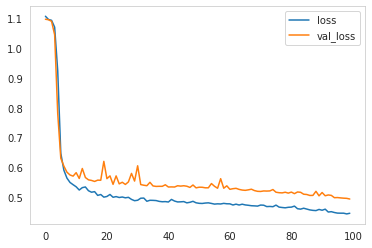

In [ ]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)

(52, 512, 512) (52, 512, 512)


In [ ]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP = {:6.0f}, #FP = {:6.0f}, #FN = {:5.0f}, IoU = {:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)

class 00: #TP =    303, #FP =  23821, #FN = 293643, IoU = 0.001
class 01: #TP = 10754954, #FP = 2249883, #FN = 150332, IoU = 0.818
class 02: #TP = 447399, #FP = 155128, #FN = 1984857, IoU = 0.173
_________________
Mean IoU: 0.330


In [ ]:
#shape = (224,224)
n_classes = 3

for i in range(50):
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg, n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()

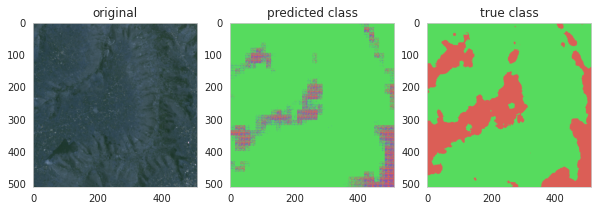

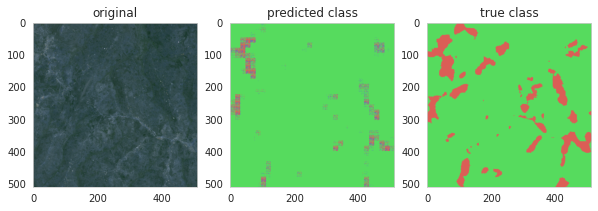

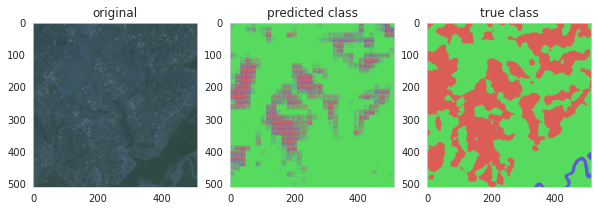

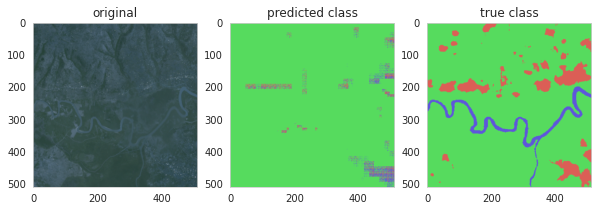

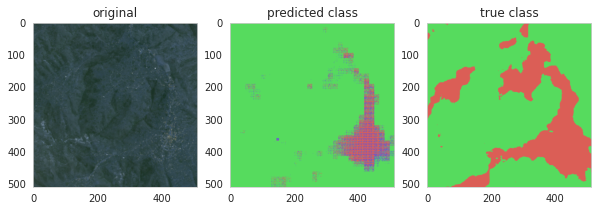

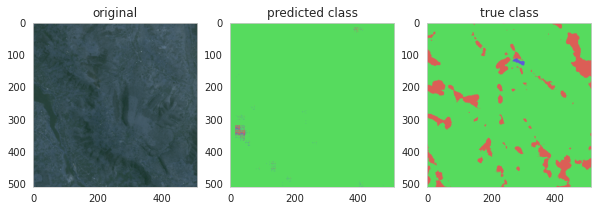

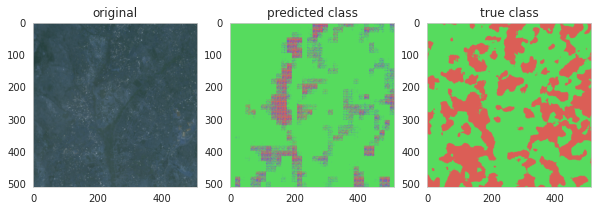

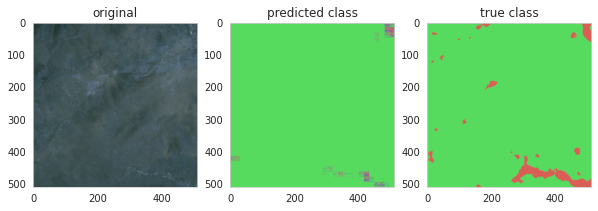

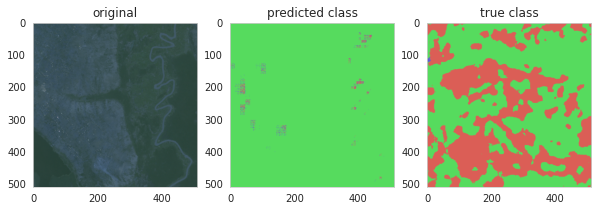

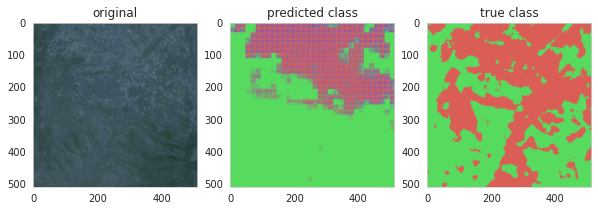

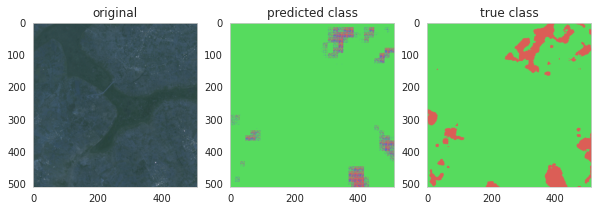

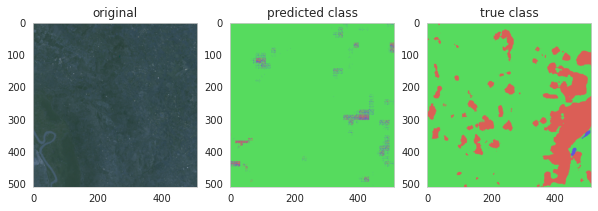

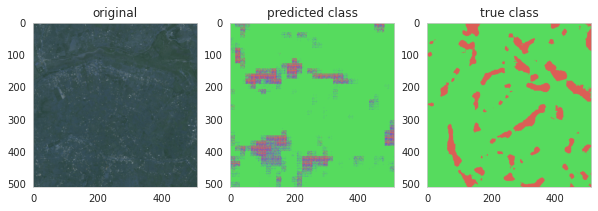

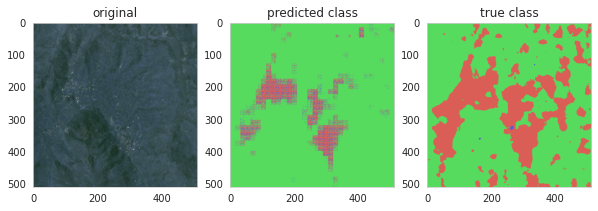

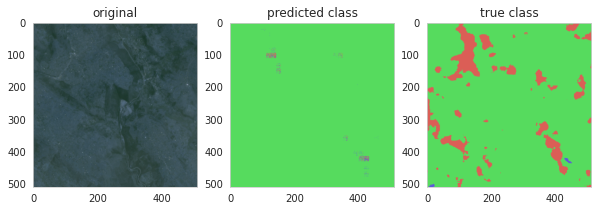

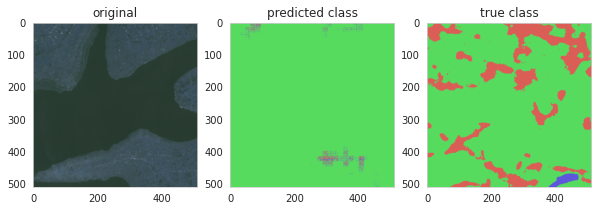

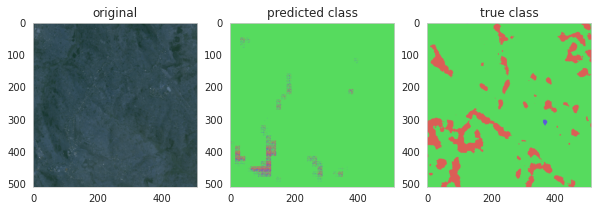

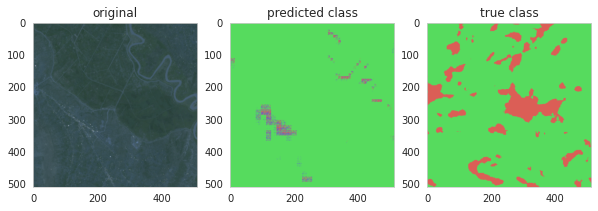

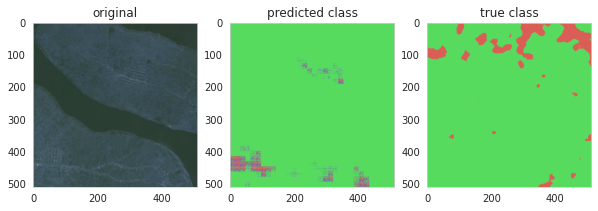

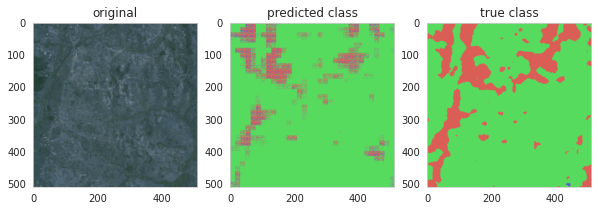

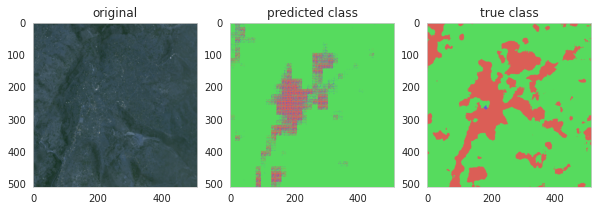

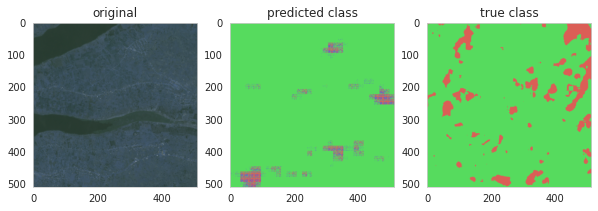

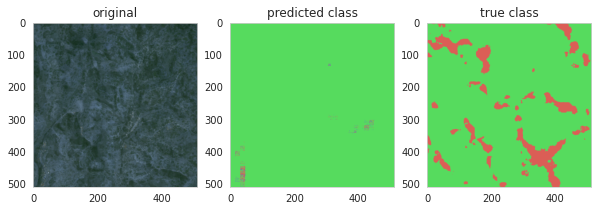

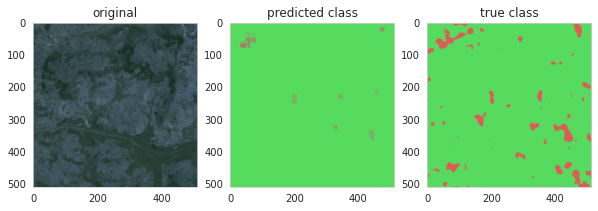

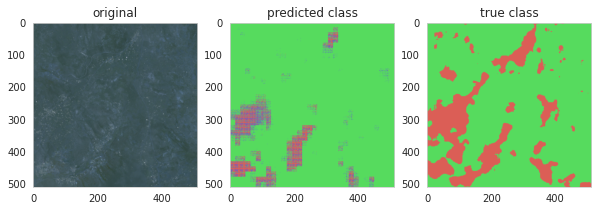

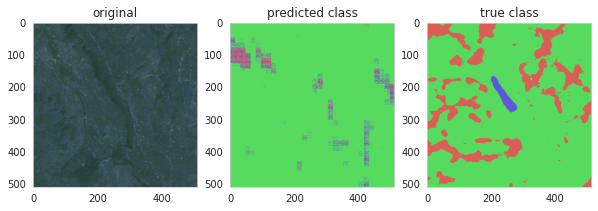

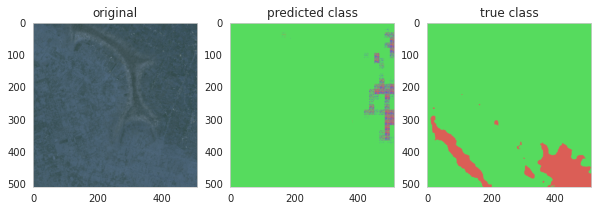

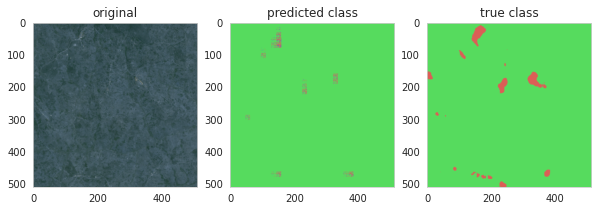

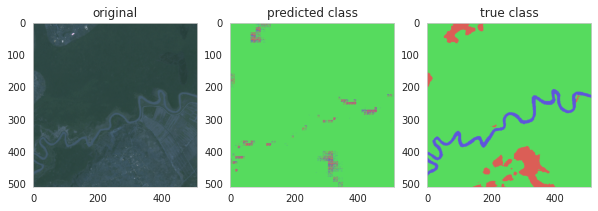

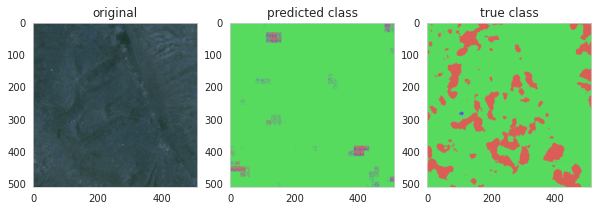

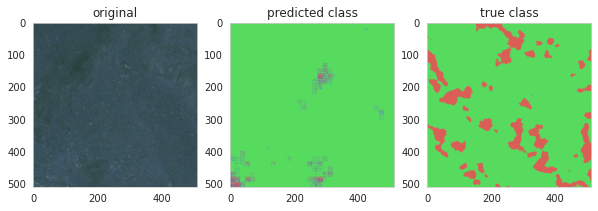

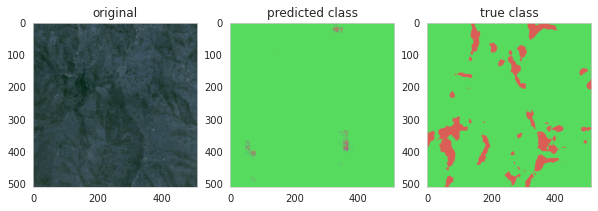

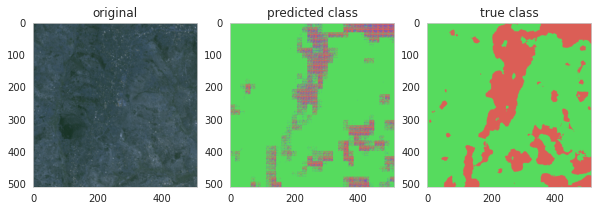

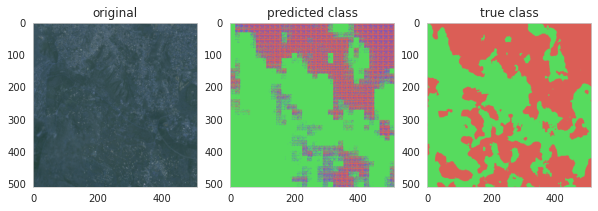

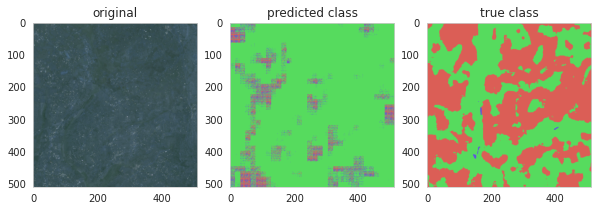

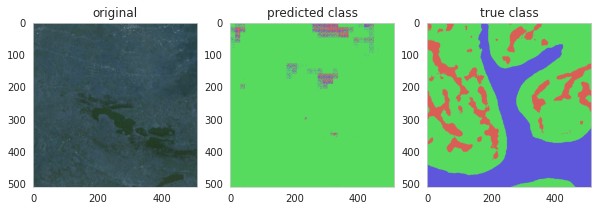

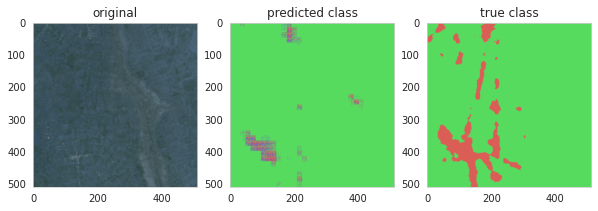

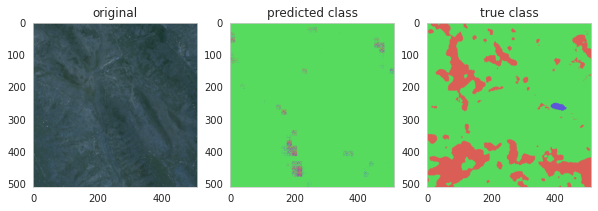

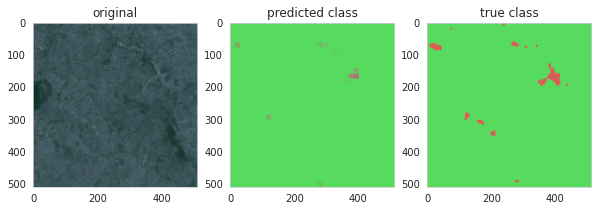

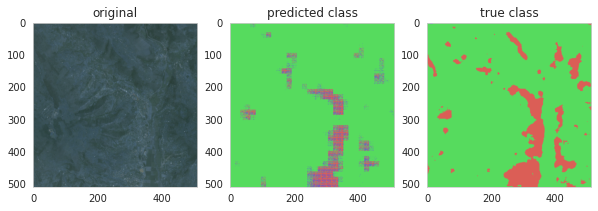

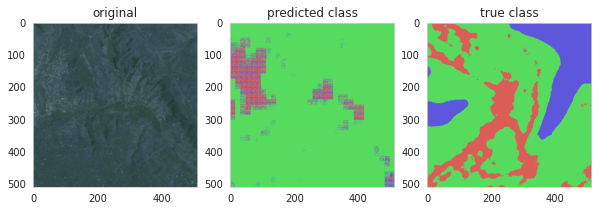

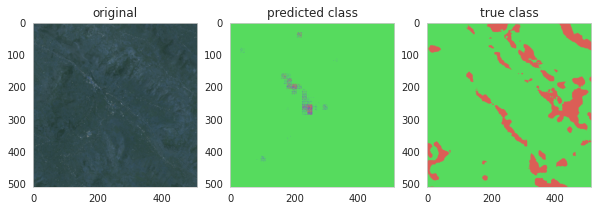

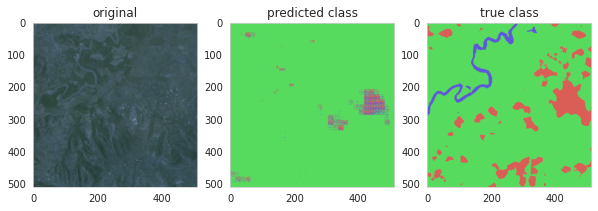

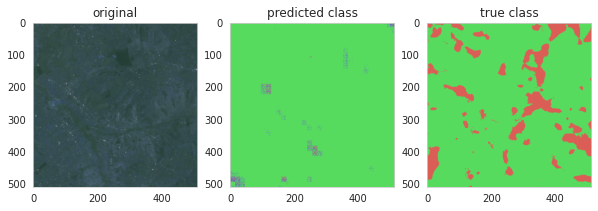

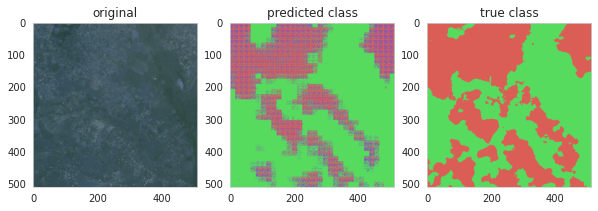

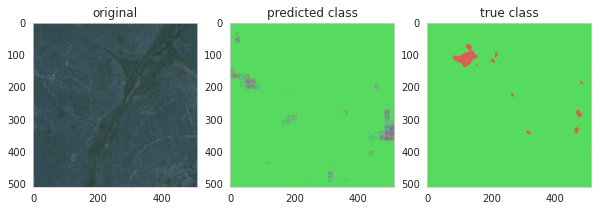

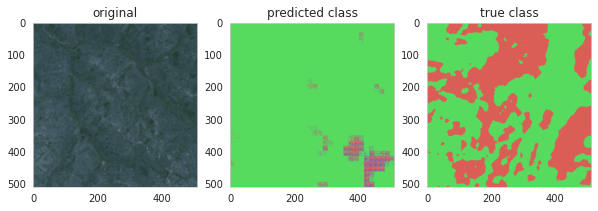

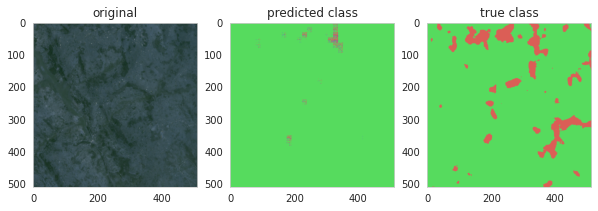

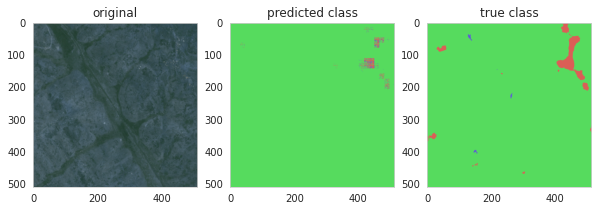

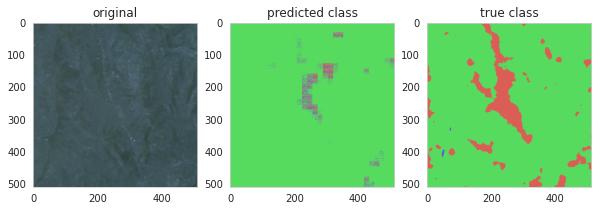

In [ ]:
#shape = (224,224)
n_classes = 3

for i in range(50):
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_pred[i].round()
    segtest = y_testi[i]

    pred_np = np.zeros((512, 512))
    for i in range(len(seg)):
      for j in range(512):
        if max(seg[i, j, :]) == seg[i, j, :][0]:
          pred_np[i, j] = 0
        elif max(seg[i, j, :]) == seg[i, j, :][1]:
          pred_np[i, j] = 1
        else:
          pred_np[i, j] = 2

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(pred_np, n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()